In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import resample

from seiz_eeg.dataset import EEGDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from data.dataset import EEGDatasetWrapper

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

import wandb
from tqdm import tqdm


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class EEGGraphFeatureDataset(torch.utils.data.Dataset):
    def __init__(self, eeg_dataset, window_size=500, overlap=0.5):
        self.eeg_dataset = eeg_dataset
        self.window_size = window_size
        self.overlap = overlap

    def __len__(self):
        return len(self.eeg_dataset)

    def __getitem__(self, idx):
        signal, label = self.eeg_dataset[idx]  # signal shape: (seq_len, num_electrodes)
        features = self.extract_graph_features(signal)  # (num_windows, feature_dim)
        return features, label

    def extract_graph_features(self, signal):
        seq_len, num_electrodes = signal.shape
        step = int(self.window_size * (1 - self.overlap))
        windows = []

        for start in range(0, seq_len - self.window_size + 1, step):
            windows.append(signal[start:start+self.window_size])

        windows = np.array(windows)
            
        windows = torch.stack([torch.tensor(w) for w in windows])  # shape: (num_windows, window_size, num_electrodes)
        num_windows = windows.shape[0]

        features = torch.zeros(num_windows, 2) 

        for i in range(num_windows):
            w = windows[i]
            corr = torch.corrcoef(w.T)**2
            # replace NaN values with 0
            corr = torch.nan_to_num(corr)
            features[i] = torch.tensor([corr.mean(), corr.std()])
        return features  # shape: (num_windows, feature_dim)


In [3]:
data_root = "data/data"
data_preprocessing = "raw"
eeg_data_wrapper= EEGDatasetWrapper(
    data_root,
    data_preprocessing)

In [4]:
selected_ids = eeg_data_wrapper.get_subject_ids()
validation_id = "s002" 
selected_ids.remove(validation_id)
train_dataset, val_dataset = eeg_data_wrapper.leave_one_out_split(
        validation_id, selected_ids
)

labels = train_dataset.get_label_array()
labels = np.array(labels)
# get ratio positive and negative samples
pos_ratio = np.sum(labels == 0) / np.sum(labels == 1)
print(f"Positive ratio: {pos_ratio:.2f}")

train_dataset = EEGGraphFeatureDataset(train_dataset, window_size=500, overlap=0.5)
val_dataset = EEGGraphFeatureDataset(val_dataset, window_size=500, overlap=0.5)
test_data , label = train_dataset.__getitem__(0)

print(f"Test data shape: {test_data.shape}")
print (test_data)

Positive ratio: 4.00
Test data shape: torch.Size([11, 2])
tensor([[0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.5972, 0.3185],
        [0.3105, 0.3063],
        [0.2685, 0.2655],
        [0.2821, 0.2804]])


In [5]:
train_loader = DataLoader(
        train_dataset, batch_size=32, shuffle=True
    )
val_loader = DataLoader(val_dataset, batch_size=32,shuffle = True)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv

class EEG_GAT_Model(nn.Module):
    def __init__(self, input_dim, gat_hidden_dim=64, output_dim=1, gat_heads=8):
        super(EEG_GAT_Model, self).__init__()
        self.num_electrodes = 19
        self.gat_heads = gat_heads
        self.input_dim = input_dim  # number of features per node

        # GAT layers
        self.gat1 = GATv2Conv(in_channels=input_dim, out_channels=gat_hidden_dim, heads=gat_heads, concat=True)
        self.gat2 = GATv2Conv(in_channels=gat_hidden_dim * gat_heads, out_channels=gat_hidden_dim, heads=1, concat=True)

        # Attention pooling over graph nodes
        self.attention_pool = nn.Linear(gat_hidden_dim, 1)

        # Final classifier
        self.fc = nn.Linear(gat_hidden_dim, output_dim )

    def build_fully_connected_graph(self, num_nodes):
        edge_index = [[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j]
        return torch.tensor(edge_index, dtype=torch.long).t()


    def forward(self, x):
        """
        Args:
            x: Tensor of shape (batch_size, num_nodes, input_dim)
        Returns:
            logits: Tensor of shape (batch_size,)
        """
        batch_size, num_nodes, feature_dim = x.shape
        edge_index = self.build_fully_connected_graph(num_nodes).to(x.device)

        graph_outputs = []

        for b in range(batch_size):
            node_features = x[b]  # (num_nodes, feature_dim)
            out = self.gat1(node_features, edge_index)
            out = F.elu(out)
            out = self.gat2(out, edge_index)

            attn_scores = torch.softmax(self.attention_pool(out), dim=0)
            pooled = (attn_scores * out).sum(dim=0)  # (hidden_dim,)
            graph_outputs.append(pooled)

        graph_outputs = torch.stack(graph_outputs, dim=0)  # (batch_size, hidden_dim)
        logits = self.fc(graph_outputs)  # (batch_size, output_dim)
        return logits.squeeze(1)  # (batch_size,)




In [7]:
class BinaryFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        """
        alpha: weight for class 1
        gamma: focusing parameter
        reduction: 'mean', 'sum' or 'none'
        """
        super(BinaryFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, labels):
        """
        logits: raw model output (before sigmoid), shape (batch,)
        labels: ground truth labels (0 or 1), shape (batch,)
        """
        probs = torch.sigmoid(logits)
        probs = probs.clamp(min=1e-7, max=1 - 1e-7)  # numerical stability
        labels = labels.float()

        p_t = probs * labels + (1 - probs) * (1 - labels)
        alpha_t = self.alpha * labels + (1 - self.alpha) * (1 - labels)

        focal_term = (1 - p_t) ** self.gamma
        loss = -alpha_t * focal_term * torch.log(p_t + 1e-9)

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 15
model = EEG_GAT_Model(input_dim=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)
#loss_fn = BinaryFocalLoss(alpha=0.75, gamma=2.0, reduction='mean')

pos_weight = torch.tensor([pos_ratio])
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

wandb.init(
    project="EEG_GAT",  # give your project a name
    config={
        "epochs": num_epochs,
        "learning_rate": 1e-3,
        "loss": "BinaryFocalLoss",
        "alpha": 0.75,
        "gamma": 2.0,
        "model": "EEG_Graph_Builder"
    }
)


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for step, (x_batch, y_batch) in enumerate(loop):
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()

        logits = model(x_batch)
        loss = loss_fn(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        avg_loss = running_loss / (step + 1)
        scheduler.step(avg_loss)
        loop.set_postfix(loss=avg_loss)
        wandb.log({"batch_loss": loss.item(), "avg_loss": avg_loss, "epoch": epoch + 1})
        




/Users/charlesboissier/miniforge3/envs/network/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
wandb: Currently logged in as: cboissier77 (cboissier77-epfl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Validation Loss: 1.1128
Accuracy: 0.8002
F1 Score: 0.0000


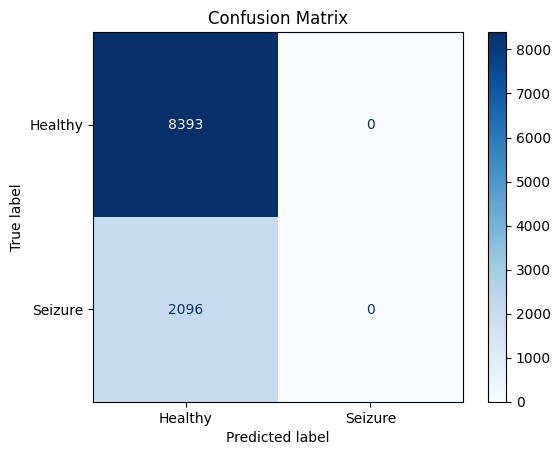

In [9]:
model.eval()
val_loss = 0.0
predictions = []
true_labels = []
with torch.no_grad():
    loop = tqdm(train_loader, desc="Validation", leave=False)
    for step, (x_batch, y_batch) in enumerate(loop):
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()

        logits = model(x_batch)
        loss = loss_fn(logits, y_batch)

        val_loss += loss.item()

        preds = torch.sigmoid(logits).cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(y_batch.cpu().numpy())

        avg_val_loss = val_loss / (step + 1)
        loop.set_postfix(val_loss=avg_val_loss)

# summarize results
predictions = np.array(predictions)
true_labels = np.array(true_labels)
# summary statistics
accuracy = accuracy_score(true_labels, (predictions > 0.5).astype(int))
f1 = f1_score(true_labels, (predictions > 0.5).astype(int))
roc_auc = roc_auc_score(true_labels, predictions)

print(f"Validation Loss: {avg_val_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
#print number of pred == 1
# plot confusion matrix
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


cm = confusion_matrix(true_labels, (predictions > 0.5).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Seizure"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()